In [105]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
import gc
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm.notebook import tqdm
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn import model_selection
import lightgbm as lgbm
import warnings

warnings.filterwarnings('ignore')

Достаточно много коллег по цеху жалуется на то, что с набором несколько тяжело начать работать <br />
в colab и, действительно, при считывании не хватает памяти. <br />
Большая проблема - нет чтения по батчам. <br />
Есть много разных WA, например, считать по колонкам, но одним <br />
из самых канонических подходов будет, пожалуй, использовать **Dask** <br />

1. Если **Dask** не был установлен, то нужно воспользоваться командой:
```
!pip install dask[dataframe]
```
2. Убедитесь, что данные доступны для ноутбука. В колабе это можно сделать примерно так
```
!wget https://boosters.pro/api/ch/files/pub/data_fusion_train.parquet
```

In [106]:
%%time
data = dd.read_parquet('../assets/data/raw/data_fusion_train.parquet').compute()

CPU times: user 19.2 s, sys: 6.18 s, total: 25.4 s
Wall time: 24.9 s


# Немного посмотрим на объем и тип данных

In [107]:
data.shape

(26094077, 9)

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int64  
 1   receipt_dayofweek  int32  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float64
 5   item_price         int64  
 6   item_nds_rate      int32  
 7   category_id        int64  
 8   brands             object 
dtypes: float64(1), int32(2), int64(3), object(3)
memory usage: 1.7+ GB


Имеются "жирные" поля типа object, которые можно перекодировать для сокращения потребления памяти, <br />
если такой проблемы нет (памяти очень много), то можно двигаться дальше

In [109]:
data.head()

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
0,7,5,09:50,Флуконазол капс 150мг №1 Вертекс,1.0,7,-1,-1,вертекс
1,11,6,20:34,"Молоко 3,2%,шт",2.0,8,2,78,None
2,39,4,11:28,"Борщ Станичный с тушенкой, 103 ккал (завод, з/у)",1.0,6,1,-1,None
3,39,4,11:28,"Компот из изюма, 114 ккал",1.0,4,1,71,None
4,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.0,4,1,71,None


In [110]:
data.describe()

,receipt_id,receipt_dayofweek,item_quantity,item_price,item_nds_rate,category_id
count,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07
mean,5.008370e+06,3.079493e+00,1.413864e+09,8.723268e+00,2.315496e+00,2.537151e+01
std,2.891319e+06,1.989730e+00,5.106975e+12,3.769641e+00,2.240315e+00,5.376522e+01
min,2.000000e+00,0.000000e+00,1.000000e-03,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,2.505699e+06,1.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,-1.000000e+00
50%,5.008298e+06,3.000000e+00,1.000000e+00,9.000000e+00,2.000000e+00,-1.000000e+00
75%,7.511943e+06,5.000000e+00,1.000000e+00,1.100000e+01,4.000000e+00,-1.000000e+00
max,1.001617e+07,6.000000e+00,1.844674e+16,4.200000e+01,6.000000e+00,2.040000e+02


Опираясь на статистику по полям, приходим к выводам, <br />
что параметры по умолчанию уж очень много съедают памяти и <br />
нужно сократить их чем-то таким:

In [111]:
map_column_to_type = {
    'category_id': np.int16,
    'item_nds_rate': np.int16,
    'item_price': np.int16,
    'item_quantity': np.float32,
    'receipt_dayofweek': np.int16,
    'receipt_id': np.int32,
#     'receipt_time': pd.StringDtype(),
#     'item_name': pd.StringDtype(),
#     'brands': pd.StringDtype()
}

Забегая в перед, к сожалению, приведение receipt_time, item_name, brands - пришлось отложить, <br />
так как новый тип StringArray не подружился с CatBoost.

In [112]:
for key in map_column_to_type:
    data[key] = data[key].astype(map_column_to_type[key])

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int32  
 1   receipt_dayofweek  int16  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float32
 5   item_price         int16  
 6   item_nds_rate      int16  
 7   category_id        int16  
 8   brands             object 
dtypes: float32(1), int16(4), int32(1), object(3)
memory usage: 1.2+ GB


Видим теперь очень хорошее сокрощение потребления памяти (почти 500Mb)

# И совсем немного взглянем на данные...

In [114]:
count_category = data['category_id'].value_counts().reset_index()

In [115]:
count_category.columns = ['category', 'count']

In [116]:
pd.set_option('max.columns', 200)

In [13]:
count_category.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
category,-1,203,84,80,78,71,83,77,69,204,79,38,74,70,81,0,40,73,130,76,139,75,85,145,117,82,92,61,68,51,72,67,7,30,66,49,2,118,45,43,3,177,133,120,50,36,62,52,57,19,20,29,114,42,37,12,31,4,150,103,140,41,9,138,96,107,167,163,109,128,6,27,115,53,90,26,11,164,60,24,13,105,56,101,111,39,35,102,54,55,108,58,100,1,106,97,46,143,121
count,19610851,1307260,902507,670833,503199,422085,322656,193369,186312,136271,126837,126410,101648,94482,93440,92280,88427,88121,80566,80476,71907,69004,67961,64365,55324,45508,41629,39821,30077,26690,24865,21723,17756,17168,16823,16274,15502,15353,14597,14362,12159,11764,10960,10836,9015,7838,6749,6160,5933,5774,5378,5298,4939,4804,4687,4657,4194,3930,3783,3695,3252,2871,2569,2565,2443,2377,2064,2042,1988,1914,1814,1787,1710,1646,1642,1470,1435,1388,1158,1149,801,741,690,626,612,507,480,459,456,444,406,356,312,226,183,109,67,25,1


Помним "-1" - товары без определенной категории

Товары с категорий -1 - встречаться не будут в тесте, поэтому их можно удалить <br />
или отложить, чтобы переиспользовать каким-то образом. 

В своем baseline просто осводимся от них для простоты

In [14]:
data = data[data['category_id'] != -1]

In [15]:
data.shape

(6483226, 9)

Набор значительно сократился, давай продолжим его сокращать!

По информации из чата известно, что метрика будет рассчитываться <br />
на уникальных товарах (отличаются по item_name) 

In [16]:
data[data['item_name'].duplicated()]

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
150,356,2,13:07,Пакет,1.0,3,6,203,None
185,558,1,13:55,Пакет,1.0,3,6,203,None
195,562,5,15:29,Пакет,1.0,0,1,203,None
226,674,6,13:19,Пакет,1.0,2,6,203,None
491,1005,5,22:20,Пакет,1.0,3,1,203,None
...,...,...,...,...,...,...,...,...,...
45729256,10016106,6,12:18,Мороженое ЗОЛОТОЙ СТАНДАРТ рож,1.0,9,2,73,None
45729264,10016106,6,12:18,Пакет,1.0,3,1,203,None
45729277,10016136,6,17:08,Пакет,1.0,3,1,203,None
45729279,10016149,1,11:08,Печень по-строгановски,1.0,8,1,71,None


Видим, что основная часть данных просто дубликаты! <br />
Т.к. мы уже выбрали модель - boosting и знаем, что он не хранит состояние. <br />
Нам нужно делать предсказание категории относительно одной и той же сущност: <br />

```
150	356	2	13:07	Пакет	1.0	3	6	203	<NA>
185	558	1	13:55	Пакет	1.0	3	6	203	<NA>
``` 
Одна и та же сущность - пакет, но она представлена разными точками данных, <br />
Для нас это будет шумом, поэтому такие дубликаты нужно убрать каким-то способом -

можно просто удалить, например, так:

```
    df_uni = data[data.category_id != -1].drop_duplicates('item_name')
```

но лучше усреднить данные, чтобы получить "среднюю сущность"


In [17]:
gr_item_name = data.groupby('item_name')
data['mean_item_quantity'] = gr_item_name['item_quantity'].transform("mean")
data['sum_item_quantity'] = gr_item_name['item_quantity'].transform("sum")
data['std_item_quantity'] = gr_item_name['item_quantity'].transform("std")
data['min_item_quantity'] = gr_item_name['item_quantity'].transform("min")
data['max_item_quantity'] = gr_item_name['item_quantity'].transform("max")

data['mean_item_price'] = gr_item_name['item_price'].transform("mean")
data['sum_item_price'] = gr_item_name['item_price'].transform("sum")
data['std_item_price'] = gr_item_name['item_price'].transform("std")
data['min_item_price'] = gr_item_name['item_price'].transform("min")
data['max_item_price'] = gr_item_name['item_price'].transform("max")

data['mean_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("mean")
data['sum_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("sum")
data['std_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("std")
data['min_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("min")
data['max_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("max")


data['hours'] = data['receipt_time'].apply(lambda x: int(x.split(":")[0]))

data['mean_hours'] = gr_item_name['hours'].transform("mean")
data['sum_hours'] = gr_item_name['hours'].transform("sum")
data['std_hours'] = gr_item_name['hours'].transform("std")
data['min_hours'] = gr_item_name['hours'].transform("min")
data['max_hours'] = gr_item_name['hours'].transform("max")


data['median_dayofweek'] = gr_item_name['receipt_dayofweek'].transform('median')
data['median_dayofweek'] = data['median_dayofweek'].astype(np.int8)

In [18]:
df_uni = data.drop_duplicates('item_name')

In [19]:
df_uni.shape

(48225, 31)

Размер внушительно уменьшился!

## А давай-ка посмотрим на самых ярких представителей своих классов...

Если у тебя не было нужных либ, то выполни команду:
  ```
   pip install wordcloud
  ```

In [20]:
!pip install wordcloud

In [21]:
count_category.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
category,-1,203,84,80,78,71,83,77,69,204,79,38,74,70,81,0,40,73,130,76,139,75,85,145,117,82,92,61,68,51,72,67,7,30,66,49,2,118,45,43,3,177,133,120,50,36,62,52,57,19,20,29,114,42,37,12,31,4,150,103,140,41,9,138,96,107,167,163,109,128,6,27,115,53,90,26,11,164,60,24,13,105,56,101,111,39,35,102,54,55,108,58,100,1,106,97,46,143,121
count,19610851,1307260,902507,670833,503199,422085,322656,193369,186312,136271,126837,126410,101648,94482,93440,92280,88427,88121,80566,80476,71907,69004,67961,64365,55324,45508,41629,39821,30077,26690,24865,21723,17756,17168,16823,16274,15502,15353,14597,14362,12159,11764,10960,10836,9015,7838,6749,6160,5933,5774,5378,5298,4939,4804,4687,4657,4194,3930,3783,3695,3252,2871,2569,2565,2443,2377,2064,2042,1988,1914,1814,1787,1710,1646,1642,1470,1435,1388,1158,1149,801,741,690,626,612,507,480,459,456,444,406,356,312,226,183,109,67,25,1


In [22]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [23]:
def get_text_all_category(data, category_id):
    text = " "
    category = data[data.category_id == category_id]
    for idx, row in tqdm(category.iterrows(), total=category.shape[0]):
        text += row['item_name'] + " "
    return text

def plot_category(data, category_id, figsize=(7, 5)):
    plt.figure(figsize=figsize)
    category = get_text_all_category(data, category_id)
    wordcloud = WordCloud(max_font_size=40).generate(category)
    print(f'Category: {category_id}')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


Category: 203


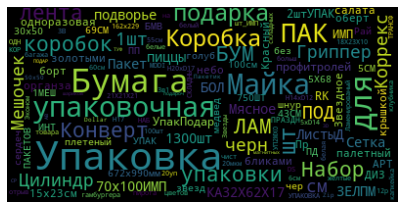

In [24]:
plot_category(df_uni, 203)


Category: 35


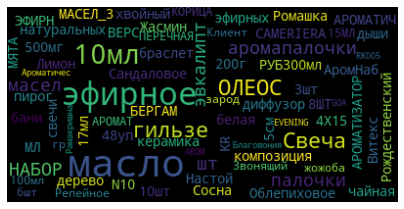

In [25]:
plot_category(df_uni, 35)


Category: 46


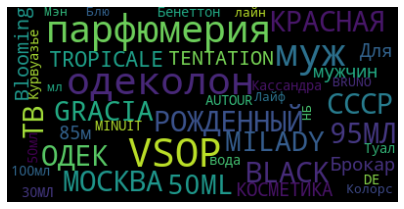

In [26]:
plot_category(df_uni, 46)


Category: 100


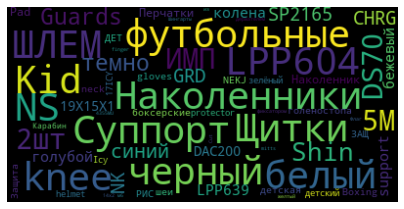

In [27]:
plot_category(df_uni, 100)


Category: 101


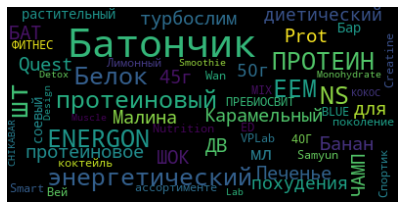

In [28]:
plot_category(df_uni, 101)

Посмотрели немного данные, теперь предлагаю перейти к моделированию. <br />
В качестве модели для разнородных данных, типа наших, подходит бустинг - в нашем случае будет - CatBoost. <br />
Благодаря относительно новым возможностям, CatBoost позволяет сразу использовать все разнородные признаки <br />

**Не забывай, что нам также нужна "хорошая" валидация, иначе рискуем просто улететь на привате!**

In [29]:
train, valid = model_selection.train_test_split(df_uni,
                                                test_size=0.10, 
                                                stratify=df_uni['category_id'], 
                                                shuffle=True, random_state=10)

In [30]:
train.head()

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,mean_item_quantity,sum_item_quantity,std_item_quantity,min_item_quantity,max_item_quantity,mean_item_price,sum_item_price,std_item_price,min_item_price,max_item_price,mean_item_nds_rate,sum_item_nds_rate,std_item_nds_rate,min_item_nds_rate,max_item_nds_rate,hours,mean_hours,sum_hours,std_hours,min_hours,max_hours,median_dayofweek
216804,474787,3,10:37,EGOISTE ESPRESSO МОЛ,1.0,13,1,84,egoiste,1.285714,27.0,0.643650,1.0,3.0,13.142857,276.0,0.358569,13,14,1.0,21.0,0.0,1,1,10,14.809524,311,3.400280,8,21,2
12663919,7717680,5,13:56,ПОДСВЕТКА НЕОНОВАЯ 1 МЕТР БЕЛАЯ 12-24 В,1.0,14,1,128,None,1.333333,4.0,0.577350,1.0,2.0,14.000000,42.0,0.000000,14,14,1.0,3.0,0.0,1,1,13,15.666667,47,4.618802,13,21,5
852935,1877634,4,20:13,КАПУСТА КВАШ КИСЛО-СЛАДКАЯ 1КГ,1.0,11,1,75,None,1.223881,82.0,0.755202,1.0,6.0,10.985075,736.0,0.122169,10,11,1.0,67.0,0.0,1,1,20,14.611940,979,4.441387,4,22,4
3182690,6969354,1,08:25,Энергетический напиток С.О.В.А. Апельсин,1.0,10,1,83,None,1.000000,3.0,0.000000,1.0,1.0,10.000000,30.0,0.000000,10,10,1.0,3.0,0.0,1,1,8,14.666667,44,6.110101,8,20,1
1554564,3411092,5,12:08,"Растворитель Р-4 0,5л ЯСХИМ",1.0,10,6,108,ясхим,1.076923,14.0,0.277350,1.0,2.0,9.615385,125.0,0.506370,9,10,6.0,78.0,0.0,6,6,12,13.384615,174,2.180920,11,18,4


CatBoost позволяет сразу принять <br />
и *числовые признаки*, <br />
и *категории*, <br />
и даже *текст*

In [31]:
print(list(train.columns))

['receipt_id', 'receipt_dayofweek', 'receipt_time', 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 'category_id', 'brands', 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 'min_item_quantity', 'max_item_quantity', 'mean_item_price', 'sum_item_price', 'std_item_price', 'min_item_price', 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 'hours', 'mean_hours', 'sum_hours', 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek']


In [32]:
feature_names = ['receipt_id', 'receipt_dayofweek', 'receipt_time', 
                 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 
                 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 
                 'min_item_quantity', 'max_item_quantity', 'mean_item_price',
                 'sum_item_price', 'std_item_price', 'min_item_price',
                 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 
                 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 
                 'hours', 'mean_hours', 'sum_hours', 
                 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek'] #+ feature_probs

cat_features = ['receipt_time', 'receipt_id']
text_features = ['item_name']

target = 'category_id'

Зададим гиперпараметры: если верить разным докладам от Яндекса, то у CatBoost 2 крайне важных гиперпараметра:
1. Число деревьев
2. Learning rate

Если есть GPU, то можно еще и время ожидания сократить в разы - нужно добавить
```
   task_type='GPU'
```

TotalF1 - как раз нам подходит в качестве метрики (взвешенный F1)

In [33]:
model = CatBoostClassifier(
    cat_features=cat_features,
    text_features=text_features,
    verbose=50,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type="GPU",
    iterations=1000,
    learning_rate=0.2,            
)

In [34]:
model.fit(
    train[feature_names], train[target],
    eval_set=(valid[feature_names], valid[target]),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1407685	test: 0.1391385	best: 0.1391385 (0)	total: 162ms	remaining: 2m 42s
50:	learn: 0.6283717	test: 0.6559391	best: 0.6567690 (49)	total: 7.01s	remaining: 2m 10s
100:	learn: 0.6504432	test: 0.6703656	best: 0.6703656 (100)	total: 13.6s	remaining: 2m 1s
150:	learn: 0.6643241	test: 0.6760500	best: 0.6761983 (136)	total: 20.3s	remaining: 1m 54s
200:	learn: 0.6757109	test: 0.6843292	best: 0.6850322 (192)	total: 27s	remaining: 1m 47s
250:	learn: 0.6847438	test: 0.6855347	best: 0.6855347 (250)	total: 33.7s	remaining: 1m 40s
300:	learn: 0.6933486	test: 0.6860448	best: 0.6883083 (262)	total: 40.4s	remaining: 1m 33s
350:	learn: 0.6998196	test: 0.6888143	best: 0.6890356 (335)	total: 47.1s	remaining: 1m 27s
400:	learn: 0.7059664	test: 0.6888049	best: 0.6902620 (372)	total: 53.8s	remaining: 1m 20s
450:	learn: 0.7110452	test: 0.6905830	best: 0.6908523 (444)	total: 1m	remaining: 1m 13s
500:	learn: 0.7168596	test: 0.6933128	best: 0.6940046 (499)	total: 1m 7s	remaining: 1m 6s
550:	learn: 

Легким движением руки (в fit установить флаг plot=True) - и мы можем отслеживать <br>
необходимые показатели при обучении. <br />

"Хорошее" число итераций советуют брать на уровне зеленой точки. <br />
Крайне важно, чтобы точка не была полностью в конце либо далеко от конца.

Судя по графику - у нас пошло переобучение (небольшое)
В реальном мире, скорее всего мы бы остановились на 300 итерациях, где у нас <br />
показатели на тренировке и валидации близки - предпочтение ушло бы более стабильной модели.

Но здесь конкурс, поэтому хотим выжать все соки, конечно, стараемся не получать очень большого <br />
разброса. например, с помощью регуляризации, но все же позволяем модельке чуть переобучиться, чтобы получить больше показатели, но менее стабильную модель (может на привате быть менее хороша)

# А поиграемся с текстом

In [35]:
feature_names = ['receipt_id', 'receipt_dayofweek', 'receipt_time', 
                 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 
                 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 
                 'min_item_quantity', 'max_item_quantity', 'mean_item_price',
                 'sum_item_price', 'std_item_price', 'min_item_price',
                 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 
                 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 
                 'hours', 'mean_hours', 'sum_hours', 
                 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek',
                 
                 'first',
                 'last', 'is_preservativ', 'is_paper', 'is_otkritka', 'is_born', 'is_a4', 'is_ubiley',                                         
                 'is_auto', 'is_list', 'is_kanc', 'is_dnevnik',
                
                'first_word_len', 'last_word_len',
                 'second_last_word', 'second_first_word',
                 
                 'last_first_word',
                ] 

cat_features = ['receipt_time', 'receipt_id', 'hours', 'min_hours', 'max_hours', 
                'median_dayofweek', 'first', 'last', 'second_last_word', 'second_first_word',
                 'last_first_word']
text_features = ['item_name']

target = 'category_id'
                

In [36]:
train.head()

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,mean_item_quantity,sum_item_quantity,std_item_quantity,min_item_quantity,max_item_quantity,mean_item_price,sum_item_price,std_item_price,min_item_price,max_item_price,mean_item_nds_rate,sum_item_nds_rate,std_item_nds_rate,min_item_nds_rate,max_item_nds_rate,hours,mean_hours,sum_hours,std_hours,min_hours,max_hours,median_dayofweek
216804,474787,3,10:37,EGOISTE ESPRESSO МОЛ,1.0,13,1,84,egoiste,1.285714,27.0,0.643650,1.0,3.0,13.142857,276.0,0.358569,13,14,1.0,21.0,0.0,1,1,10,14.809524,311,3.400280,8,21,2
12663919,7717680,5,13:56,ПОДСВЕТКА НЕОНОВАЯ 1 МЕТР БЕЛАЯ 12-24 В,1.0,14,1,128,None,1.333333,4.0,0.577350,1.0,2.0,14.000000,42.0,0.000000,14,14,1.0,3.0,0.0,1,1,13,15.666667,47,4.618802,13,21,5
852935,1877634,4,20:13,КАПУСТА КВАШ КИСЛО-СЛАДКАЯ 1КГ,1.0,11,1,75,None,1.223881,82.0,0.755202,1.0,6.0,10.985075,736.0,0.122169,10,11,1.0,67.0,0.0,1,1,20,14.611940,979,4.441387,4,22,4
3182690,6969354,1,08:25,Энергетический напиток С.О.В.А. Апельсин,1.0,10,1,83,None,1.000000,3.0,0.000000,1.0,1.0,10.000000,30.0,0.000000,10,10,1.0,3.0,0.0,1,1,8,14.666667,44,6.110101,8,20,1
1554564,3411092,5,12:08,"Растворитель Р-4 0,5л ЯСХИМ",1.0,10,6,108,ясхим,1.076923,14.0,0.277350,1.0,2.0,9.615385,125.0,0.506370,9,10,6.0,78.0,0.0,6,6,12,13.384615,174,2.180920,11,18,4


У CatBoost'a есть возможность обрабатывать текст из коробки, для этого нужно лишь указать, эту текстовую колонку:

```
text_features=[name_your_text_feature]
```
Так же модели нужно сообщить какие из колонок считать категориальными
```
cat_features=[your_categorical_feature]
```
Учтите, что категориальные переменные не должны содержать Nan зачений - CatBoost не поддерживает из коробки их 
заполнение, а вот если Nan есть в числовых значениях, работает очень даже хорошо.


В работе CatBoost'a есть 3 этапа:
1. Токенизация
2. Создание словаря
3. Подсчет признаков


Конфигурировать весь процесс можно через text_processing, передав вложенный словарь.

Для простоты:
1. токенизация будет по пробелу (нужно задать токенизатор)
2. создадим 2-6 gram'ы (нужно создать соответствующие словари)
3. выполним подсчет признаков (укажим какие признаки подсчитываем на словаре)


Пример словаря: 

```
{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
}
```

Создали словарь 3-грам (gram_order - этот параметр определяет какой вид n-gram'a создается),
на символах (token_level_type, поддерживается еще уровень Word),
нижняя граница частоты 3-граммы равна 1 (occurrence_lower_bound),
так же нужно указать размер словаря (это скажется на предварительных подсчетах)


Затем нужно посчитать признаки. CatBoost позволяет считать 3 вида признаков:
1. Bow (Bag-of-Words)
2. NaiveBayes 
3. BM25 

[Про эти особенности можно почитать здесь](https://catboost.ai/docs/search/?query=BM25)
        
И [более понятно на примерах здесь](https://github.com/catboost/tutorials/blob/master/text_features/text_features_in_catboost.ipynb)

In [37]:
model = CatBoostClassifier(
    cat_features=cat_features,
    text_features=text_features,
    verbose=50,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type="GPU",
    iterations=1000,
    learning_rate=0.2,      
#     reg_lambda=0.0001,
    
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "150000",
            "occurrence_lower_bound" : "1",
            "gram_order" : "2"
        },{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
        },{
            "dictionary_id" : "Fourgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "4"
        },{
            "dictionary_id" : "Fivegram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "5"
        },{
            "dictionary_id" : "Sixgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "6"
        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)



In [38]:
def create_features(data):
    data['first'] = data['item_name'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    data['last'] = data['item_name'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else 'none')
    data['is_preservativ'] = data.item_name.apply(lambda x: int('презерватив' in x.lower()))
    data['is_auto'] = data.item_name.apply(lambda x: int('авто' in x.lower() or \
                                                            'щетк' in x.lower() or \
                                                             'сантиметр' in x.lower()))

    data['is_paper'] = data.item_name.apply(lambda x: int('бумага' in x.lower()))
    data['is_otkritka'] = data.item_name.apply(lambda x: int('открытка' in x.lower()))
    data['is_born'] = data.item_name.apply(lambda x: int('рождения' in x.lower()))
    data['is_a4'] = data.item_name.apply(lambda x: int('а4' in x.lower()))
    data['is_ubiley'] = data.item_name.apply(lambda x: int('юбиле' in x.lower()))

    #24
    data['is_list'] = data.item_name.apply(lambda x: int('лист' in x.lower()))
    data['is_kanc'] = data.item_name.apply(lambda x: int('канцелярский' in x.lower()))
    data['is_dnevnik'] = data.item_name.apply(lambda x: int('дневник' in x.lower()))
    
    data['second_last_word'] = data.item_name.apply(lambda x: x.split()[-2] if len(x.split()) > 1 else 'none')
    data['second_first_word'] = data.item_name.apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'none')

    data['first_word_len'] = data['first'].apply(len)
    data['last_word_len'] = data['last'].apply(len)

    data['item_name_len'] = data.item_name.apply(lambda x: len(x.split()))

    data['last_first_word'] = data['last'] + data['first']
    return data

In [39]:
train = create_features(train)

valid = create_features(valid)

# Посмотрим, нет ли у нас пропусков, так как поиск std часто их дает

In [40]:
train.isnull().sum()

receipt_id                0
receipt_dayofweek         0
receipt_time              0
item_name                 0
item_quantity             0
item_price                0
item_nds_rate             0
category_id               0
brands                36704
mean_item_quantity        0
sum_item_quantity         0
std_item_quantity      7315
min_item_quantity         0
max_item_quantity         0
mean_item_price           0
sum_item_price            0
std_item_price         7315
min_item_price            0
max_item_price            0
mean_item_nds_rate        0
sum_item_nds_rate         0
std_item_nds_rate      7315
min_item_nds_rate         0
max_item_nds_rate         0
hours                     0
mean_hours                0
sum_hours                 0
std_hours              7315
min_hours                 0
max_hours                 0
median_dayofweek          0
first                     0
last                      0
is_preservativ            0
is_auto                   0
is_paper            

Как и ожидалось, пропуски есть - заполним их медианой

In [41]:
def fill_median(df):
    df['std_item_quantity'] = df['std_item_quantity'].fillna(np.nanmedian(df['std_item_quantity']))
    df['std_item_price'] = df['std_item_price'].fillna(np.nanmedian(df['std_item_price']))
    df['std_item_nds_rate'] = df['std_item_nds_rate'].fillna(np.nanmedian(df['std_item_nds_rate']))
    df['std_hours'] = df['std_hours'].fillna(np.nanmedian(df['std_hours']))
    return df

In [42]:
train = fill_median(train)
valid = fill_median(valid)

In [43]:
train.isnull().sum()

receipt_id                0
receipt_dayofweek         0
receipt_time              0
item_name                 0
item_quantity             0
item_price                0
item_nds_rate             0
category_id               0
brands                36704
mean_item_quantity        0
sum_item_quantity         0
std_item_quantity         0
min_item_quantity         0
max_item_quantity         0
mean_item_price           0
sum_item_price            0
std_item_price            0
min_item_price            0
max_item_price            0
mean_item_nds_rate        0
sum_item_nds_rate         0
std_item_nds_rate         0
min_item_nds_rate         0
max_item_nds_rate         0
hours                     0
mean_hours                0
sum_hours                 0
std_hours                 0
min_hours                 0
max_hours                 0
median_dayofweek          0
first                     0
last                      0
is_preservativ            0
is_auto                   0
is_paper            

In [44]:
model.fit(
    train[feature_names], train[target],
    eval_set=(valid[feature_names], valid[target]),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1755967	test: 0.1897938	best: 0.1897938 (0)	total: 280ms	remaining: 4m 39s
50:	learn: 0.7052533	test: 0.7395048	best: 0.7395048 (50)	total: 12.3s	remaining: 3m 49s
100:	learn: 0.7390728	test: 0.7651854	best: 0.7659653 (97)	total: 24.2s	remaining: 3m 35s
150:	learn: 0.7625084	test: 0.7738773	best: 0.7740864 (149)	total: 36.5s	remaining: 3m 25s
200:	learn: 0.7811714	test: 0.7805735	best: 0.7805735 (200)	total: 48.9s	remaining: 3m 14s
250:	learn: 0.7997546	test: 0.7872413	best: 0.7872413 (250)	total: 1m 1s	remaining: 3m 3s
300:	learn: 0.8146703	test: 0.7892521	best: 0.7892521 (300)	total: 1m 13s	remaining: 2m 51s
350:	learn: 0.8287127	test: 0.7925444	best: 0.7945387 (331)	total: 1m 26s	remaining: 2m 39s
400:	learn: 0.8417842	test: 0.7944028	best: 0.7945387 (331)	total: 1m 38s	remaining: 2m 27s
450:	learn: 0.8537010	test: 0.7958459	best: 0.7963220 (420)	total: 1m 50s	remaining: 2m 14s
500:	learn: 0.8649109	test: 0.7959619	best: 0.7964647 (490)	total: 2m 2s	remaining: 2m 2s
550:

In [45]:
import pickle
from sklearn.metrics import classification_report

In [46]:
print(classification_report(valid.category_id.values, model.predict(valid[feature_names])))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       236
           1       1.00      0.67      0.80         3
           2       0.93      0.88      0.90        32
           3       1.00      1.00      1.00        11
           4       0.74      0.61      0.67        23
           6       1.00      0.50      0.67         6
           7       1.00      0.95      0.98        22
           9       0.91      1.00      0.95        10
          11       1.00      0.20      0.33         5
          12       0.67      0.78      0.72        18
          13       0.00      0.00      0.00         4
          19       0.75      0.43      0.55         7
          20       1.00      0.67      0.80         6
          24       1.00      0.14      0.25         7
          26       0.00      0.00      0.00         2
          27       0.00      0.00      0.00         4
          29       0.77      0.77      0.77        13
          30       0.55    

Если посмотреть на confusion matrix, то видим, что достаточно много контраста - некоторые классы определены 
с высокой точностью, но некоторые классы определены как 0. Прослеживается некоторая связь между количеством
записей на валидации и в целом точностью, но т.к. наша модель крайне близко предсказывает локально и удаленно, <br>
то это говорит о близости входных распределений на тесте и трейне. Нужно поработать над предсказанием классов с низкими показателями.

Как это можно сделать?
1. Разметить неразмеченные данные, хотя бы частично
2. Добавить признаки, посчитанные вручную - boosting открывает широко двери в этом направлении
3. Улучшить токенизацию

# A препроцессинг?

In [53]:
import nltk
import string
from nltk.tokenize import WordPunctTokenizer 

In [48]:
!mkdir nltk_models

## Скачаем модели, чтобы их можно было потом упаковать

In [50]:
nltk.download('punkt', download_dir='nltk_models')
nltk.download('stopwords', download_dir='nltk_models')

[nltk_data] Downloading package punkt to nltk_models...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to nltk_models...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# А библиотеку тоже можно?

Возьмем для примера библиотеку для токенизации razdel 

In [57]:
!git clone https://github.com/natasha/razdel.git

Cloning into 'razdel'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 505 (delta 88), reused 101 (delta 51), pack-reused 343
Receiving objects: 100% (505/505), 42.67 MiB | 18.83 MiB/s, done.
Resolving deltas: 100% (297/297), done.


In [65]:
!pip uninstall -y razdel

In [68]:
from razdel import tokenize
from nltk.corpus import stopwords

In [78]:
RU_STOP_WORDS = set(stopwords.words('russian'))

# def prepare(token):
#     return re.sub("[^0-9A-Za-zА-Яа-я ]", "", token)
    

def pre_process(text):
    return " ".join([token.lower() for token in [_.text for _ in tokenize(text)]
                     if (token not in RU_STOP_WORDS) or (token not in string.punctuation)])

# Давай препроцессить?!

In [79]:
# train['item_name'] = train['item_name_tmp'].values
# valid['item_name'] = valid['item_name_tmp'].values

In [80]:
train['item_name_tmp'] = train['item_name'].values
valid['item_name_tmp'] = valid['item_name'].values

train['item_name'] = train.item_name.apply(pre_process)
valid['item_name'] = valid.item_name.apply(pre_process)

In [81]:
train = create_features(train)

valid = create_features(valid)

In [82]:
train = fill_median(train)
valid = fill_median(valid)

In [83]:
model.fit(
    train[feature_names], train[target],
    eval_set=(valid[feature_names], valid[target]),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1753661	test: 0.1824299	best: 0.1824299 (0)	total: 269ms	remaining: 4m 28s
50:	learn: 0.7342351	test: 0.7643490	best: 0.7643490 (50)	total: 12.5s	remaining: 3m 51s
100:	learn: 0.7646722	test: 0.7882761	best: 0.7882761 (100)	total: 24.3s	remaining: 3m 36s
150:	learn: 0.7862550	test: 0.7963697	best: 0.7974998 (147)	total: 36.6s	remaining: 3m 25s
200:	learn: 0.8052340	test: 0.7991712	best: 0.7993417 (199)	total: 48.9s	remaining: 3m 14s
250:	learn: 0.8200050	test: 0.8035329	best: 0.8035390 (249)	total: 1m	remaining: 3m 1s
300:	learn: 0.8308510	test: 0.8037536	best: 0.8043078 (296)	total: 1m 12s	remaining: 2m 48s
350:	learn: 0.8420119	test: 0.8071080	best: 0.8079591 (342)	total: 1m 24s	remaining: 2m 35s
400:	learn: 0.8535798	test: 0.8100683	best: 0.8101458 (392)	total: 1m 36s	remaining: 2m 23s
450:	learn: 0.8606876	test: 0.8108045	best: 0.8108412 (449)	total: 1m 47s	remaining: 2m 10s
500:	learn: 0.8682284	test: 0.8113784	best: 0.8114395 (476)	total: 1m 58s	remaining: 1m 58s
550:

# Mmmm Not Bad... мы даже улучшились... но переобучились... скор становится не таким надежным...

В терминах Bias-Variance: Variance модели возросла, а вот Bias понизился.

#### Что же делать???

Способы понизить дисперсию:

1. Больше данных Богу данных!
2. Нужно сделать модель более простой:
    * меньше итераций/деревьев
    * больше регуляризации



# Кто на свете всех главнее?

In [97]:
importance = model.get_feature_importance(prettified=True)
importance

,Feature Id,Importances
0,item_name,77.664951
1,first,6.013969
2,last_first_word,3.927846
3,second_first_word,2.857196
4,receipt_id,1.136130
5,last,1.081226
6,first_word_len,0.763383
7,mean_item_price,0.753818
8,item_price,0.698055
9,min_hours,0.626168


В целом, было очень ожидаемо, что именно item_name будет самым главным признаком. <br>
Очень хорошо зашли категориальные признаки.

Давайте проведем анализ: где модель ошибается чаще всего. <br>
Для этого возьмем жирный класс 84, статистика которого будет более-менее показательной

In [98]:
valid['pred'] = model.predict(valid[feature_names])

In [99]:
valid[valid['category_id'] == 84].sample(50)

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,mean_item_quantity,sum_item_quantity,std_item_quantity,min_item_quantity,max_item_quantity,mean_item_price,sum_item_price,std_item_price,min_item_price,max_item_price,mean_item_nds_rate,sum_item_nds_rate,std_item_nds_rate,min_item_nds_rate,max_item_nds_rate,hours,mean_hours,sum_hours,std_hours,min_hours,max_hours,median_dayofweek,first,last,is_preservativ,is_auto,is_paper,is_otkritka,is_born,is_a4,is_ubiley,is_list,is_kanc,is_dnevnik,second_last_word,second_first_word,first_word_len,last_word_len,item_name_len,last_first_word,item_name_tmp,pred
4187,8449,3,13:23,100 г шок ritter ром орех изюм,1.000,9,1,84,ritter,1.898085,6444.000,2.303998,1.000,48.000,8.753756,29719.0,0.520114,8,10,1.000000,3395.0,0.000000,1,1,13,15.702209,53309,4.087577,0,23,4,100,изюм,0,0,0,0,0,0,0,0,0,0,орех,г,3,4,7,изюм100,100Г ШОК RITTER РОМ ОРЕХ ИЗЮМ,81
22064232,8276462,1,09:21,треугольник с капустой с кур,1.000,6,-1,84,None,1.000000,2.000,0.000000,1.000,1.000,6.000000,12.0,0.000000,6,6,-1.000000,-2.0,0.000000,-1,-1,9,10.000000,20,1.414214,9,11,1,треугольник,кур,0,0,0,0,0,0,0,0,0,0,с,с,11,3,5,куртреугольник,ТРЕУГОЛЬНИК С КАПУСТОЙ С КУР,84
5819517,2732016,1,15:28,пч овсяное 5 кг ( баженов ) ( кор ),1.000,15,6,84,None,1.000000,1.000,0.353553,1.000,1.000,15.000000,15.0,0.266258,15,15,6.000000,6.0,0.000000,6,6,15,15.000000,15,3.535534,15,15,1,пч,),0,0,0,0,0,0,0,0,0,0,кор,овсяное,2,1,10,)пч,пч Овсяное 5кг (Баженов)(кор),84
12698593,7793336,3,20:07,вафли шоколайт 180 г яшкино,1.000,7,-1,84,None,1.166667,7.000,0.408248,1.000,2.000,7.833333,47.0,0.408248,7,8,4.833333,29.0,2.857738,-1,6,20,16.000000,96,6.260990,7,21,3,вафли,яшкино,0,0,0,0,0,0,0,0,0,0,г,шоколайт,5,6,5,яшкиновафли,Вафли Шоколайт 180г Яшкино,84
1011758,2221802,5,12:07,витушка сырная 105 г / срок реализации 48 ч /,1.000,8,6,84,None,1.000000,8.000,0.000000,1.000,1.000,8.000000,64.0,0.000000,8,8,6.000000,48.0,0.000000,6,6,12,15.250000,122,3.011881,12,19,3,витушка,/,0,0,0,0,0,0,0,0,0,0,ч,сырная,7,1,10,/витушка,Витушка Сырная 105г /срок реализации 48ч/,84
150756,332428,6,18:31,шоколадный торт,1.000,13,3,84,None,1.216000,152.000,0.590025,1.000,5.000,11.944000,1493.0,1.910514,0,14,4.168000,521.0,2.608102,-1,6,18,16.472000,2059,5.018636,0,23,4,шоколадный,торт,0,0,0,0,0,0,0,0,0,0,шоколадный,торт,10,4,2,тортшоколадный,Шоколадный торт,84
1196003,2621386,1,12:59,батон летний 350 г .,1.000,7,6,84,None,1.000000,21.000,0.000000,1.000,1.000,7.000000,147.0,0.000000,7,7,6.000000,126.0,0.000000,6,6,12,14.190476,298,4.081900,5,21,2,батон,.,0,0,0,0,0,0,0,0,0,0,г,летний,5,1,5,.батон,Батон Летний 350 г.,84
1401904,3070673,2,21:32,лаваш грузинский 1 шт,1.000,8,6,84,None,1.200000,12.000,0.421637,1.000,2.000,8.000000,80.0,0.000000,8,8,6.000000,60.0,0.000000,6,6,21,15.300000,153,6.912951,0,21,2,лаваш,шт,0,0,0,0,0,0,0,0,0,0,1,грузинский,5,2,4,штлаваш,Лаваш Грузинский 1шт,84
1333357,2921759,1,12:09,круассан со сливочным маслом,1.000,7,6,84,None,1.363636,15.000,1.206045,1.000,5.000,7.000000,77.0,0.000000,7,7,6.000000,66.0,0.000000,6,6,12,13.636364,150,3.828126,9,20,3,круассан,маслом,0,0,0,0,0,0,0,0,0,0,сливочным,со,8,6,4,масломкруассан,Круассан со сливочным маслом,84
671734,1480293,2,17:14,батончик твикс 55 гр,1.000,7,-1,84,None,1.138211,140.000,0.390989,1.000,3.000,6.878049,846.0,0.416570,6,8,0.341463,42.0,2.639018,-1,6,17,14.203252,1747,5.616077,0,23,2,батончик,гр,0,0,0,0,0,0,0,0,0,0,55,твикс,8,2,4,грбатончик,Батончик Твикс 55гр,84


Ошибаемся мы с 71, 78, 0 классами. <br>
Давайте посмотрим на основных представителей этих классов, возможно, это позволит понять причины ошибок модели



Category: 84


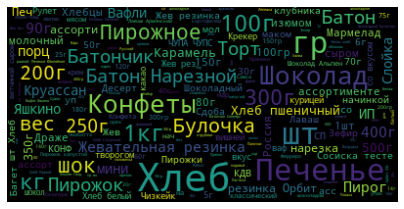

In [100]:
plot_category(df_uni, 84)


Category: 71


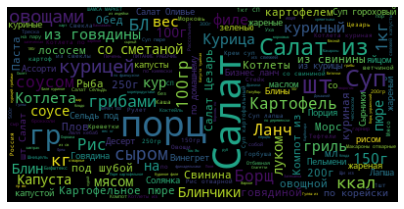

In [101]:
plot_category(df_uni, 71)


Category: 78


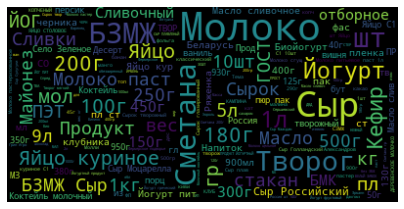

In [102]:
plot_category(df_uni, 78)


Category: 0


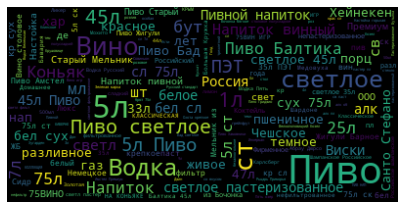

In [103]:
plot_category(df_uni, 0)

Видим, что здесь алкогольный напиток и он больше подходит к категории 0, чем к категории 84.
Скорее всего ошибка в разметке, которая добавляет шум и мешает модели - нужно исправить

```
33975448	4294383	6	22:21	ЛИМОНЧЕЛЛО	7.000	14	-1	84	
```

84, 71, 78 - все продукты питания, из разных категорий, но сложно провести точные границы, где будет заканчиваться один продукт и начинаться другой. Здесь с проверкой придется повозиться

# А заверните мне...

Сделаем все просто - создадим папку build, туда сохраним модель, script.py и упакуем тут же

In [85]:
!mkdir build 

In [87]:
!cp -r razdel build/

In [88]:
!cp -r nltk_models build/

In [89]:
folder = 'build'

In [90]:
with open(f'{folder}/catboost.clf', 'wb') as f:
    f.write(pickle.dumps(model))

In [95]:
%%writefile build/script.py

from nltk.corpus import stopwords
import string
import pandas as pd
import numpy as np
import pickle
import nltk
import sys

sys.path.append("./razdel/")


from razdel import tokenize

nltk.data.path.append("nltk_models")

feature_names = ['receipt_id', 'receipt_dayofweek', 'receipt_time', 
                 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 
                 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 
                 'min_item_quantity', 'max_item_quantity', 'mean_item_price',
                 'sum_item_price', 'std_item_price', 'min_item_price',
                 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 
                 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 
                 'hours', 'mean_hours', 'sum_hours', 
                 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek',
                 
                 'first',
                 'last', 'is_preservativ', 'is_paper', 'is_otkritka', 'is_born', 'is_a4', 'is_ubiley',                                         
                 'is_auto', 'is_list', 'is_kanc', 'is_dnevnik',
                
                'first_word_len', 'last_word_len',
                 'second_last_word', 'second_first_word',
                 'last_first_word'] 

cat_features = ['receipt_time', 'receipt_id', 'hours', 'min_hours', 'max_hours', 
                'median_dayofweek', 'first', 'last', 'second_last_word', 'second_first_word',
                 'last_first_word']
text_features = ['item_name']
RU_STOP_WORDS = set(stopwords.words('russian'))


def create_features_part_1(data):
    gr_item_name = data.groupby('item_name')
    data['mean_item_quantity'] = gr_item_name['item_quantity'].transform("mean")
    data['sum_item_quantity'] = gr_item_name['item_quantity'].transform("sum")
    data['std_item_quantity'] = gr_item_name['item_quantity'].transform("std")
    data['min_item_quantity'] = gr_item_name['item_quantity'].transform("min")
    data['max_item_quantity'] = gr_item_name['item_quantity'].transform("max")

    data['mean_item_price'] = gr_item_name['item_price'].transform("mean")
    data['sum_item_price'] = gr_item_name['item_price'].transform("sum")
    data['std_item_price'] = gr_item_name['item_price'].transform("std")
    data['min_item_price'] = gr_item_name['item_price'].transform("min")
    data['max_item_price'] = gr_item_name['item_price'].transform("max")

    data['mean_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("mean")
    data['sum_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("sum")
    data['std_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("std")
    data['min_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("min")
    data['max_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("max")


    data['hours'] = data['receipt_time'].apply(lambda x: int(x.split(":")[0]))

    data['mean_hours'] = gr_item_name['hours'].transform("mean")
    data['sum_hours'] = gr_item_name['hours'].transform("sum")
    data['std_hours'] = gr_item_name['hours'].transform("std")
    data['min_hours'] = gr_item_name['hours'].transform("min")
    data['max_hours'] = gr_item_name['hours'].transform("max")


    data['median_dayofweek'] = gr_item_name['receipt_dayofweek'].transform('median')
    data['median_dayofweek'] = data['median_dayofweek'].astype(np.int8)
    return data

def create_features_part_2(data):
    data['first'] = data['item_name'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    data['last'] = data['item_name'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else 'none')
    data['is_preservativ'] = data.item_name.apply(lambda x: int('презерватив' in x.lower()))
    data['is_auto'] = data.item_name.apply(lambda x: int('авто' in x.lower() or \
                                                            'щетк' in x.lower() or \
                                                             'сантиметр' in x.lower()))

    data['is_paper'] = data.item_name.apply(lambda x: int('бумага' in x.lower()))
    data['is_otkritka'] = data.item_name.apply(lambda x: int('открытка' in x.lower()))
    data['is_born'] = data.item_name.apply(lambda x: int('рождения' in x.lower()))
    data['is_a4'] = data.item_name.apply(lambda x: int('а4' in x.lower()))
    data['is_ubiley'] = data.item_name.apply(lambda x: int('юбиле' in x.lower()))

    #24
    data['is_list'] = data.item_name.apply(lambda x: int('лист' in x.lower()))
    data['is_kanc'] = data.item_name.apply(lambda x: int('канцелярский' in x.lower()))
    data['is_dnevnik'] = data.item_name.apply(lambda x: int('дневник' in x.lower()))
    
    data['second_last_word'] = data.item_name.apply(lambda x: x.split()[-2] if len(x.split()) > 1 else 'none')
    data['second_first_word'] = data.item_name.apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'none')

    data['first_word_len'] = data['first'].apply(len)
    data['last_word_len'] = data['last'].apply(len)

    data['item_name_len'] = data.item_name.apply(lambda x: len(x.split()))

    data['last_first_word'] = data['last'] + data['first']
    return data


def fill_median(df):
    df['std_item_quantity'] = df['std_item_quantity'].fillna(np.nanmedian(df['std_item_quantity']))
    df['std_item_price'] = df['std_item_price'].fillna(np.nanmedian(df['std_item_price']))
    df['std_item_nds_rate'] = df['std_item_nds_rate'].fillna(np.nanmedian(df['std_item_nds_rate']))
    df['std_hours'] = df['std_hours'].fillna(np.nanmedian(df['std_hours']))
    return df



def pre_process(text):
    return " ".join([token.lower() for token in [_.text for _ in tokenize(text)]
                     if (token not in RU_STOP_WORDS) or (token not in string.punctuation)])

def main():
    test = pd.read_parquet('data/task1_test_for_user.parquet')

    with open("catboost.clf", 'rb') as fout:
        clf = pickle.loads(fout.read())
    
    test['item_name'] = test.item_name.apply(pre_process)
    
    test = create_features_part_1(test)
    test = create_features_part_2(test)
    test = fill_median(test)

    pred = clf.predict(test[feature_names])
    res = pd.DataFrame(pred, columns=['pred'])
    res['id'] = test['id'].values
    res[['id', 'pred']].to_csv('answers.csv', index=None)



if __name__ == "__main__":
    main()

Overwriting build/script.py


Сейчас уже нужен zip, если нет и у тебя линукс, то используй:

```
sudo apt install zip unzip
```

In [96]:
!cd build && zip -r build_v2.zip catboost.clf script.py nltk_models razdel && cd ..

  adding: catboost.clf (deflated 80%)
  adding: script.py (deflated 76%)
  adding: nltk_models/ (stored 0%)
  adding: nltk_models/corpora/ (stored 0%)
  adding: nltk_models/corpora/stopwords.zip (stored 0%)
  adding: nltk_models/corpora/stopwords/ (stored 0%)
  adding: nltk_models/corpora/stopwords/french (deflated 56%)
  adding: nltk_models/corpora/stopwords/romanian (deflated 57%)
  adding: nltk_models/corpora/stopwords/tajik (deflated 62%)
  adding: nltk_models/corpora/stopwords/README (deflated 59%)
  adding: nltk_models/corpora/stopwords/hungarian (deflated 51%)
  adding: nltk_models/corpora/stopwords/turkish (deflated 38%)
  adding: nltk_models/corpora/stopwords/italian (deflated 62%)
  adding: nltk_models/corpora/stopwords/russian (deflated 58%)
  adding: nltk_models/corpora/stopwords/finnish (deflated 65%)
  adding: nltk_models/corpora/stopwords/azerbaijani (deflated 48%)
  adding: nltk_models/corpora/stopwords/swedish (deflated 45%)
  adding: nltk_models/corpora/stopwords/kaza

### UPD
Наша оценка на тестовом наборе
bestTest = 0.8181563086

Оценка на PLB
0.8161839294508318

Получили крайне близкий скор!
Хороший знак, что на привате мы не сильно улетим, но с большим Bias'ом нужно бороться.

Итак, мы научились читать данные, смогли посмотреть на представителей классов, <br>
настроили валидацию, построили модель и даже провели анализ ошибок. <br>
Наш локальный скор очень близок с лидербордом, что является хорошим показателем не улететь на  <br>
приватной часте. Так же удалось наметить дальнейшии пути улучшения модели, а в конце мы все это смешали <br>
и упаковали в поставку на стенд.

#### UPD: Теперь мы можем даже упаковывать библиотечки, даже немного обработали текст...Но впереди еще очень много работы =)